

## Deep Learning Coursework **

**Description**: Create a code using this template to train a Convolutional Neural Network (CNN) on the fashion MNIST dataset available at https://keras.io/api/datasets/fashion_mnist/ . 

Fashion MNIST is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

The dataset should be imported in the code and one sample image should be visualised before applying the model.

Define a CNN and comment the chosen parameters of the network. Apply a regularization method (L1, L2 or L1L2). Divide the dataset into training, validation and test set. Obtain the accuracy on the validation set and plot the final results using the data from the test set.


In [1]:
# importing of modules for CIFAR-10 CNN 
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.regularizers import l1
from keras.regularizers import l1_l2

# importing of service libraries
import numpy as np
import matplotlib.pyplot as plt

2023-02-24 14:31:30.912493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 14:31:30.912526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from sklearn.model_selection import KFold

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

sample_image = x_train[0]

# consider them as float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 
x_test /= 255  

# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)


# convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train,10 )
y_test = utils.to_categorical(y_test, 10)

# Define the number of folds
k = 5

# Split the data into k folds
kfold = KFold(k, shuffle=True, random_state=0)

# concatenate the data in preparation for the kfold split
combined_x_data = np.concatenate((x_train, x_test))
combined_y_data = np.concatenate((y_train, y_test))

In [4]:
combined_y_data.shape

(70000, 10)

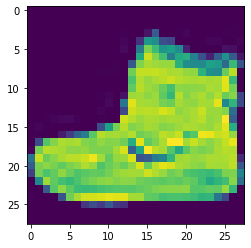

In [5]:
plt.imshow(sample_image)
plt.show() 

In [6]:
# network and training parameters
N_EPOCH = 20 
BATCH_SIZE = 128 # number of samples to be processed before updating the model
VERBOSE = 1 
OPTIMIZER = Adam()

IMG_ROWS, IMG_COLS = 28, 28 # input  dimensions of each MNIST image
N_CLASSES = 10  # number of fashion categories
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1) # input shape to be fed into the convolutional layers

# Images have to be reshaped from matrices to a single long row
RESHAPED = 784

# Instantiate a Keras model with sequential layers
model = Sequential()

# The first convolutional layer has zero padding so as to not ignore the edges (rows & columns) of the images
# Using relu as it is fast to compute
model.add(Conv2D(32, kernel_size=3, padding="same", input_shape=INPUT_SHAPE, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Second convolutional layer
model.add(Conv2D(64, kernel_size=3, padding="same", input_shape=INPUT_SHAPE, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Flatten all the layers to be added into the 
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=l2(0.01))) 
model.add(Activation('relu'))
model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(Dense(N_CLASSES)) # 10 different fashion categories
model.add(Activation('softmax')) # using the activation softmax as it is a multiclass classification problem
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

2023-02-23 15:42:47.481231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-23 15:42:47.481270: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-23 15:42:47.481293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist
2023-02-23 15:42:47.481554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# train and test the model 

# variables to store the accuracy and losses of the training and testing data
histories = []
test_accuracies = []
test_losses = []

# split the data into kfold 
for i, (train_index, test_index) in enumerate(kfold.split(combined_x_data)):

    model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])
        
    # train and store the accuracy and loss scores
    histories.append(model.fit(combined_x_data[train_index],combined_y_data[train_index], epochs=N_EPOCH, 
        batch_size=BATCH_SIZE, verbose=VERBOSE))

    # test the model and store the results
    results = model.evaluate(combined_x_data[test_index], combined_y_data[test_index])
    
    test_losses.append(results[0])
    test_accuracies.append(results[1])


Epoch 1/20
438/438 [==============================] - 16s 35ms/step - loss: 1.2051 - accuracy: 0.7966
Epoch 2/20
438/438 [==============================] - 14s 33ms/step - loss: 0.6345 - accuracy: 0.8522
Epoch 3/20
438/438 [==============================] - 14s 33ms/step - loss: 0.5238 - accuracy: 0.8660
Epoch 4/20
438/438 [==============================] - 15s 33ms/step - loss: 0.4665 - accuracy: 0.8754
Epoch 5/20
438/438 [==============================] - 14s 32ms/step - loss: 0.4372 - accuracy: 0.8802
Epoch 6/20
438/438 [==============================] - 14s 33ms/step - loss: 0.4158 - accuracy: 0.8857
Epoch 7/20
438/438 [==============================] - 14s 32ms/step - loss: 0.3966 - accuracy: 0.8904
Epoch 8/20
438/438 [==============================] - 14s 33ms/step - loss: 0.3817 - accuracy: 0.8942
Epoch 9/20
438/438 [==============================] - 14s 32ms/step - loss: 0.3714 - accuracy: 0.8964
Epoch 10/20
438/438 [==============================] - 14s 31ms/step - loss: 0.363

In [8]:
# Iterate over each fold and print out the loss and accuracy scores
cross_val_accuracies = []
cross_val_losses = []
for x in range(k):
    cross_val_accuracies.append(sum(histories[x].history['accuracy']) / N_EPOCH)
    cross_val_losses.append(sum(histories[x].history['loss']) / N_EPOCH)
    print(f'Fold {x + 1} cross validation accuracy: { cross_val_accuracies[x] }')
    print(f'Fold {x + 1} cross validation loss: { cross_val_losses[x] }')

# Obtain the validations 
average_validation_accuracy = sum(cross_val_accuracies) / k
average_validation_loss = sum(cross_val_losses) / k

# Print the results
print(f'Average cross validation accuracy: {average_validation_accuracy}')
print(f'Average cross validation loss: {average_validation_loss}')

Fold 1 cross validation accuracy: 0.8914580345153809
Fold 1 cross validation loss: 0.42327538430690764
Fold 2 cross validation accuracy: 0.9241383999586106
Fold 2 cross validation loss: 0.2786152720451355
Fold 3 cross validation accuracy: 0.9331419676542282
Fold 3 cross validation loss: 0.2506678394973278
Fold 4 cross validation accuracy: 0.9390008926391602
Fold 4 cross validation loss: 0.23310305550694466
Fold 5 cross validation accuracy: 0.9438803553581238
Fold 5 cross validation loss: 0.22000123783946038
Average cross validation accuracy: 0.9263239300251007
Average cross validation loss: 0.2811325578391552


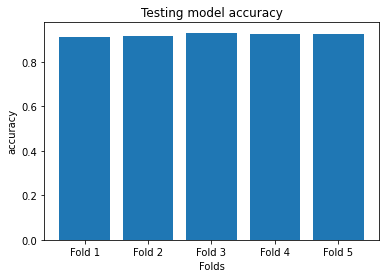

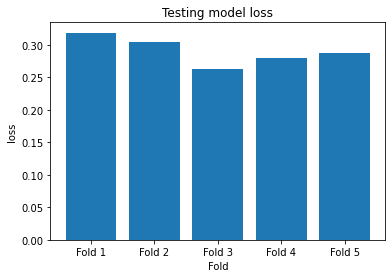

In [9]:
# generate x axis labels
axis = np.arange(k) + 1

# plot testing accuracy
labels = [ f'Fold {x + 1}' for x in range(k)]
plt.bar(labels, test_accuracies)
plt.title('Testing model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Folds')
plt.show()
 
# plot testing loss
plt.bar(labels, test_losses)
plt.title('Testing model loss')
plt.ylabel('loss')
plt.xlabel('Fold')
plt.show()


Remarks:

There was a slight drop in the network's accuracy  when applying regularisation as compared to not applying it. The regularisation used was L2. In addition to the slight drop in network's accuracy, the network's loss also significantly differed as regularisation increases loss to ensure that there is no overfitting. It is expected of regularization method L2 as it forces the model weights to be kept as small as possible, reducing them model's variance but increasing its bias. 

Overall, the accuracy of the model is quite good with testing and validation accuracy being above 80%. The loss for the validation set and testing are also fairly similar which could mean that the model is currently not overfitting or underfitting. 

Another way to improve results/performance could be perhaps to add another convolutional layer as this might provide even higher accuracy. Additionally, to further reduce the losses of the model, a different regularization technique could be used such as drop out or combining both l1 and l2 as regularization methods. Further tweaking of L2 hyperparameter could also possibly yield better results. 

